In [4]:
%pip install pygamma-agreement cylp pandas numpy tqdm scipy matplotlib


[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Computing inter-annotator agreement (IAA) with factgenie

This notebook shows how to compute inter-annotator agreement (IAA) between annotators.

# Pearson r

First, we will use the **Pearson correlation coefficient** to measure the agreement between two annotator groups.

Specifically, we will measure how much the **error counts** agree. 

In the ideal case, both annotator groups annotated the **same amount of errors of each category** for each example. The Pearson r coefficient will help us to quantify to which extent it is true. The value of 1 signifies perfect *positive linear correlation*, 0 signifies no linear correlation, -1 signifies perfect *negative linear correllation*.

In [5]:
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import logging
import traceback


def compute_pearson_r(df, group1, group2):
    group1_data = df[df['annotator_group_id'] == group1]
    group2_data = df[df['annotator_group_id'] == group2]
    
    group1_counts = list(group1_data["count"])
    group2_counts = list(group2_data["count"])

    # Micro correlation - correlation of counts
    micro_corr = pearsonr(group1_counts, group2_counts)[0]

    # Macro correlation - average of per-type correlations
    type_corrs = []
    for ann_type in df['annotation_type'].unique():
        g1_type = list(group1_data[group1_data['annotation_type'] == ann_type]["count"])
        g2_type = list(group2_data[group2_data['annotation_type'] == ann_type]["count"])

        type_corrs.append(pearsonr(g1_type, g2_type)[0])
    
    macro_corr = np.mean(type_corrs)
    
    return {'micro': micro_corr, 'macro': macro_corr, 'category_correlations': type_corrs}


### Input data
For computing Pearson r, you will need (at least one of) the CSV files generated by factgenie:
- `example_level_counts.csv` - absolute error counts for each (dataset, split, setup_id, example_idx) combination,
- `dataset_level_counts.csv` - average error counts for each (dataset, split, setup_id) combination.

You can generate these files on the `/analyze` page (on the Inter-annotator agreement tab). On that page, you need to select the campaign(s) with multiple annotators per example and select `Export data files`.


In [6]:
# Set the directory where the csv files are located here
csv_dir = "."

level = "example"

csv_filename = f"{csv_dir}/{level}_level_counts.csv"
# Load data
df = pd.read_csv(csv_filename)

### Annotator groups
We will always compute the correlation between two **annotator groups**. Each annotator group has an id in the format `{campaign_id}-anngroup-{group_idx}`. That means that it uniquely defines the ordinal number of the annotator within a specific campaign.

Example: in the campaign `llm-eval-1`, you used two annotators per example. Then you want to measure agreement between `llm-eval-1-anngroup-0` and `llm-eval-1-anngroup-1`.

In [7]:
# Use all annotator groups
groups = df.annotator_group_id.unique()

print(f"Groups: {groups}")

from itertools import combinations
group_pairs = list(combinations(groups, 2))

print(f"Group pairs: {group_pairs}")

Groups: ['quintd1-gpt-4-anngroup-0' 'quintd1-human-anngroup-0']
Group pairs: [('quintd1-gpt-4-anngroup-0', 'quintd1-human-anngroup-0')]



### Average type
- **Micro-average** - a coefficient computed over concatenated results from all the categories.
- **Macro-average** - an average of coefficients computed separately for each category.

In [8]:
# Compute correlations for all pairs of groups
for group1, group2 in group_pairs:
    correlations = compute_pearson_r(df, group1, group2)

    print(f"{level}-level correlations between {group1} and {group2}")
    print("==============================================")

    print(f"Micro Pearson-r: {correlations['micro']:.3f}")
    print("==============================================")

    for i, corr in enumerate(correlations['category_correlations']):
        print(f"Category {i}: {corr:.3f}")
    print("----------------------------------------------")

    print(f"Macro Pearson-r: {correlations['macro']:.3f}")
    print("==============================================")

example-level correlations between quintd1-gpt-4-anngroup-0 and quintd1-human-anngroup-0
Micro Pearson-r: 0.521
Category 0: 0.565
Category 1: 0.281
Category 2: 0.021
Category 3: 0.130
----------------------------------------------
Macro Pearson-r: 0.249


# Gamma (γ) score
Next, we compute the gamma (γ) score.

This score suitable for computing IAA in cases where are both (1) determining span positions and (2) categorizing the spans.

The γ score considers the best alignment between the spans and computes the value based on the number of local dissimilarities. The score will help us to quantify the correlation not just between the error counts, but also their exact **positions** on top of the output text.

For full description, please refer to the original paper [Mathet et al. (2015)](https://doi.org/10.1162/COLI_a_00227).

For Python, the score is implemented in the [pygamma-agreement](https://pygamma-agreement.readthedocs.io/en/latest/index.html) library.

**Note that computing the score is computationally intensive. Consider saving intermediate per-example scores in case you need to repeat the experiments.**

In [9]:
from IPython import display
import pygamma_agreement as pa
from pyannote.core import Segment
from tqdm.notebook import tqdm

def compute_gamma(span_index, dissim):
    gamma_scores = []
    running_avg = 0
    
    # Group examples
    groups = list(span_index.groupby(["dataset", "split", "setup_id", "example_idx"]))
    
    # Create progress bar
    pbar = tqdm(total=len(groups), desc='Computing gamma score')
    

    display.display(f"Visualization of the best alignment", display_id='vis_lbl')
    display.display(f"Waiting for the first example...", display_id='vis')
    
    for idx, (i, group) in enumerate(groups, 1):
        try:
            # Add each annotation to continuum
            continuum = pa.Continuum()

            if group.annotator_group_id.unique().shape[0] < 2:
                # One of the annotators did not add any annotation -> gamma = 0
                gamma_scores.append(0.0)
                running_avg = np.mean(gamma_scores)
                pbar.set_postfix({'avg_gamma': f'{running_avg:.3f}'})
                pbar.update(1)
                continue

            for j, row in group.iterrows():
                # make sure we do not add empty segments
                if row["annotation_start"] == row["annotation_end"]:
                    continue

                continuum.add(
                    str(row["annotator_group_id"]),
                    Segment(row["annotation_start"], row["annotation_end"]),
                    str(row["annotation_type"]),
                )

            # Temporarily increase logging level to suppress output
            logging.getLogger().setLevel(logging.WARNING)
            gamma_results = continuum.compute_gamma(dissim, soft=True)
            logging.getLogger().setLevel(logging.INFO)

            # Show the best alignment for every 10th example
            if idx % 10 == 1:
                display.update_display(f"Visualization of the best alignment for example {idx}", display_id='vis_lbl')
                display.update_display(gamma_results.best_alignment, display_id='vis')

            gamma_scores.append(gamma_results.gamma)
            running_avg = np.mean(gamma_scores)
            
            # Update progress bar with current average
            pbar.set_postfix({'avg_gamma': f'{running_avg:.3f}'})
            pbar.update(1)
        except Exception as e:
            traceback.print_exc()
            print(f"Error computing gamma for example {idx}")
            gamma_scores.append(0.0)
            running_avg = np.mean(gamma_scores)
            pbar.set_postfix({'avg_gamma': f'{running_avg:.3f}'})
            pbar.update(1)
    
    pbar.close()
    return float(np.mean(gamma_scores)) if gamma_scores else 0.0

Computing gamma score:   0%|          | 0/1881 [00:00<?, ?it/s]

'Visualization of the best alignment for example 1001'

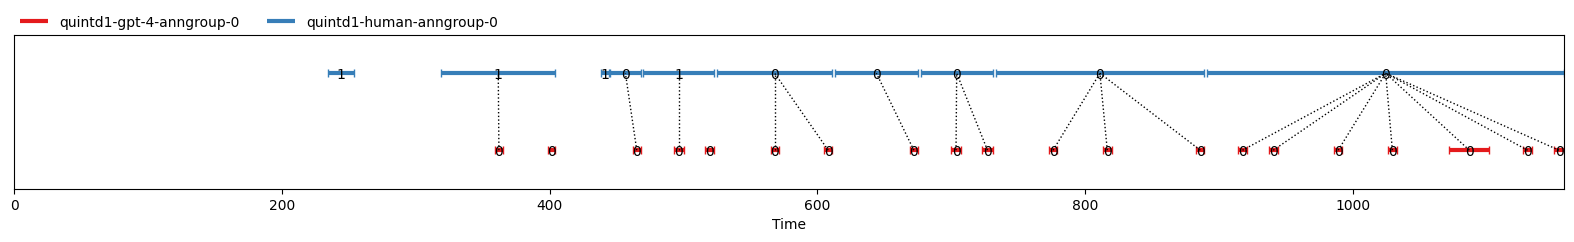

In [ ]:
gamma_spans = pd.read_csv(f"{csv_dir}/gamma_spans.csv")

# `alpha`: coefficient weighting the *positional* dissimilarity value, defaults to 1
alpha = 1
# `beta`: coefficient weighting the *categorical* dissimilarity value, defaults to 1
beta = 1
# `delta_empty`: empty dissimilarity value, defaults to 1
dissim = pa.CombinedCategoricalDissimilarity(delta_empty=1, alpha=1, beta=1)
gamma = compute_gamma(gamma_spans, dissim)

print(f"==============================================")
print(f"Gamma score: {gamma:.3f}")
print(f"==============================================")